# Minimize Integrated Squared Error

for noise-free, parametrically continuous point sequence

In [1]:
from PIL import Image
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from time import perf_counter


Generate spline

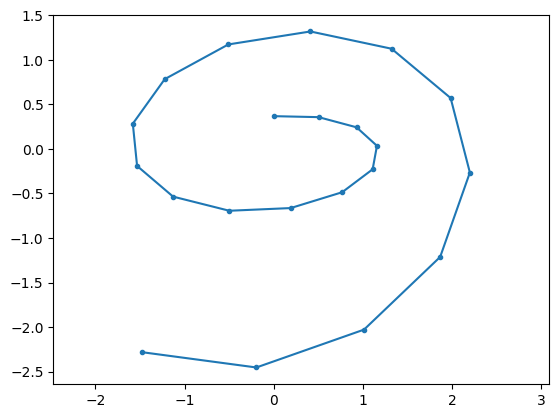

In [2]:
N = 20

def fun(t):
    return np.array([
        np.exp(t)*np.sin(10.0*t),
        np.exp(2*t-1)*np.cos(10.0*t)
    ]).T

initial_t = np.linspace(0, 1, N+1)
initial_p = fun(initial_t)

plt.figure()
plt.plot(initial_p[:,0], initial_p[:,1], '.-')
plt.axis("equal")
plt.show()

Interpolate spline (C2 cubic)

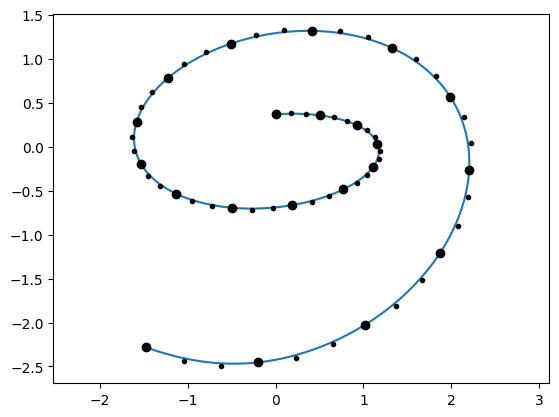

In [3]:
def compute_c1_c2(ps):
    n = len(ps)-1
    d0 = [-1.5, 2, -0.5] @ ps[:3]
    d1 = [0.5, -2, 1.5] @ ps[-3:]

    A = np.zeros((2*n, 2*n), dtype=np.double)
    b = np.zeros((2*n, 2), dtype=np.double)

    A[0,0] = 3.0
    b[0] = 3.0*ps[0] + d0
    for i in range(n-1):
        A[2*i+1, 2*i+1:2*i+3] = [1.0, 1.0]
        b[2*i+1] = 2.0*ps[i+1]
        A[2*i+2, 2*i:2*i+4] = [1.0, -2.0, 2.0, -1.0]
    A[2*n-1, 2*n-1] = 3.0
    b[2*n-1] = 3.0*ps[-1] - d1

    x = np.linalg.inv(A) @ b

    return x[2*np.arange(n)], x[2*np.arange(n)+1]


initial_c1, initial_c2 = compute_c1_c2(initial_p)

plt.figure()
for i in range(N):
    t = np.linspace(0, 1).reshape(-1, 1)
    p = (1-t)**3 * initial_p[i] + \
        3*t*(1-t)**2 * initial_c1[i] + \
        3*t**2*(1-t) * initial_c2[i] + \
        t**3 * initial_p[i+1]
    plt.plot(p[:,0], p[:,1], 'C0-')
plt.plot(initial_p[:,0], initial_p[:,1], 'ko')
plt.plot(initial_c1[:,0], initial_c1[:,1], 'k.')
plt.plot(initial_c2[:,0], initial_c2[:,1], 'k.')
plt.axis("equal")
plt.show()

Error metrics

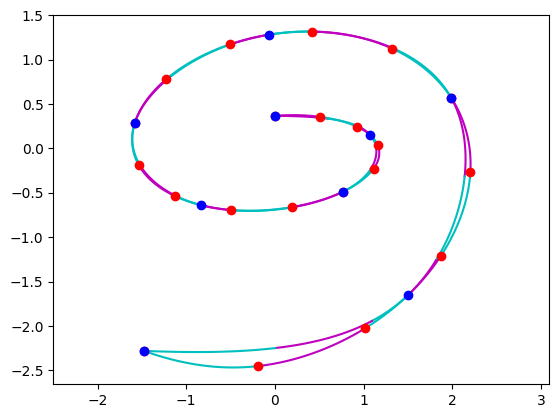

In [4]:
# https://cs.nyu.edu/~sw4429//files/paper/sa23-bezier.pdf


def unwrap_cubic_spline(cps, t0, t1):
    """Unwrap Bezier curve with control points c0,c1,c2,c3 between t0,t1 to
        polynomial spline with a0,a1,a2,a3 between 0,1"""
    coeffs = np.array([
        [1, 0, 0, 0],
        [-3, 3, 0, 0],
        [3, -6, 3, 0],
        [-1, 3, -3, 1]
    ]) @ cps
    dt = t1-t0
    return np.array([
        [1, t0, t0**2, t0**3],
        [0, dt, 2*t0*dt, 3*t0**2*dt],
        [0, 0, dt**2, 3*t0*dt**2],
        [0, 0, 0, dt**3]
    ]) @ coeffs


def get_loss(ts, ps, c1s, c2s, verbose=False):

    all_ss = []  # (s, is_initial, idx)
    for i, t in enumerate(initial_t):
        all_ss.append((t, True, i))
    for i, t in enumerate(ts):
        all_ss.append((t, False, i))
    all_ss.sort(key=lambda _: _[0])

    total_loss = 0.0
    sp0i, sp1i = 0, 0
    piece_i = 0
    for (s0, g0, i0), (s1, g1, i1) in zip(all_ss[:-1], all_ss[1:]):
        if g0:
            sp0i = i0
        else:
            sp1i = i0
        if not s0 < s1:
            continue
        piece_i += 1

        # first piece
        cps0 = (
            initial_p[sp0i], initial_c1[sp0i], initial_c2[sp0i],
            initial_p[sp0i+1]
        )
        t00, t01 = initial_t[sp0i], initial_t[sp0i+1]
        ts0 = ((s0-t00)/(t01-t00), (s1-t00)/(t01-t00))
        assert 0 <= ts0[0] < ts0[1] <= 1
        coeffs0 = unwrap_cubic_spline(cps0, *ts0)
        if verbose:
            t = np.linspace(0, 1).reshape(-1, 1)
            p = t**[0,1,2,3] @ coeffs0
            plt.plot(p[:,0], p[:,1], ['c-', 'm-'][piece_i%2])

        # second piece
        cps1 = (ps[sp1i], c1s[sp1i], c2s[sp1i], ps[sp1i+1])
        t10, t11 = ts[sp1i], ts[sp1i+1]
        ts1 = ((s0-t10)/(t11-t10), (s1-t10)/(t11-t10))
        assert 0 <= ts1[0] < ts1[1] <= 1
        coeffs1 = unwrap_cubic_spline(cps1, *ts1)
        if verbose:
            t = np.linspace(0, 1).reshape(-1, 1)
            p = t**[0,1,2,3] @ coeffs1
            plt.plot(p[:,0], p[:,1], ['c-', 'm-'][piece_i%2])

        # integral
        dc = coeffs1 - coeffs0
        dc_pows = np.einsum('ai,bi->ab', dc, dc) / np.array(
            [[1, 2, 3, 4],
             [2, 3, 4, 5],
             [3, 4, 5, 6],
             [4, 5, 6, 7]])
        loss = np.sum(dc_pows)

        # add loss
        dx0 = (ts0[1]-ts0[0])/N
        dx1 = (ts1[1]-ts1[0])/(len(ts)-1)
        # if not (abs(dx1-dx0) < 1e-6):
        #     print(dx0, dx1)
        #     assert False
        weight = dx0/(t01-t00) + dx1/(t11-t10)
        weight = dx0
        total_loss += weight * loss
    
    return total_loss


n1 = 8
ts = np.linspace(0, 1, n1+1)
ps = fun(ts)
c1s, c2s = compute_c1_c2(ps)

plt.figure()
get_loss(ts, ps, c1s, c2s, True)
plt.plot(initial_p[:,0], initial_p[:,1], 'ro')
plt.plot(ps[:,0], ps[:,1], 'bo')
plt.axis("equal")
plt.show()

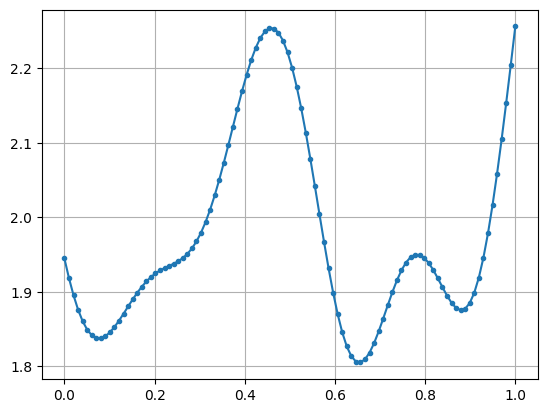

In [5]:
# make sure there's not discontinuity

n1 = 2
t_mids = np.linspace(0, 1, 100)
losses = []

for t_mid in t_mids:
    ts = np.linspace(0, 1, n1+1)
    ts[1] = t_mid
    ps = fun(ts)
    c1s, c2s = compute_c1_c2(ps)
    loss = get_loss(ts, ps, c1s, c2s)
    losses.append(loss**0.5)

plt.figure()
plt.plot(t_mids, losses, '.-')
plt.grid()
plt.show()

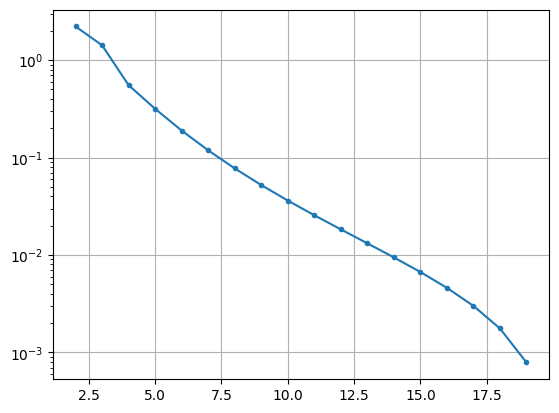

In [6]:
ns = range(2, N)
losses = []

for n1 in ns:
    ts = np.linspace(0, 1, n1+1)
    ps = fun(ts)
    c1s, c2s = compute_c1_c2(ps)
    loss = get_loss(ts, ps, c1s, c2s)
    losses.append(loss**0.5)

plt.figure()
plt.plot(ns, losses, '.-')
plt.yscale('log')
plt.grid()
plt.show()

Optimization

In [7]:
import torch
import scipy.optimize

In [48]:
# https://cs.nyu.edu/~sw4429//files/paper/sa23-bezier.pdf


def unwrap_cubic_spline_torch(cps, t0, t1):
    """Unwrap Bezier curve with control points c0,c1,c2,c3 between t0,t1 to
        polynomial spline with a0,a1,a2,a3 between 0,1"""
    coeffs = torch.tensor([
        [1, 0, 0, 0],
        [-3, 3, 0, 0],
        [3, -6, 3, 0],
        [-1, 3, -3, 1]
    ]).double() @ cps
    dt = t1-t0
    return torch.tensor([
        [1, t0, t0**2, t0**3],
        [0, dt, 2*t0*dt, 3*t0**2*dt],
        [0, 0, dt**2, 3*t0*dt**2],
        [0, 0, 0, dt**3]
    ]).double() @ coeffs


def get_loss_torch(ts, ps, c1s, c2s):
    assert ts[0].item() == 0.0
    assert ts[-1].item() == 1.0

    initial_t_torch = torch.tensor(initial_t).double()

    all_ss = []  # (s, is_initial, idx)
    for i, t in enumerate(initial_t):
        all_ss.append((t, True, i))
    for i, t in enumerate(ts):
        all_ss.append((t, False, i))
    all_ss.sort(key=lambda _: _[0])

    total_loss = 0.0
    sp0i, sp1i = 0, 0
    for (s0, g0, i0), (s1, g1, i1) in zip(all_ss[:-1], all_ss[1:]):
        if g0:
            sp0i = i0
        else:
            sp1i = i0
        if not s0 < s1:
            continue

        # first piece
        cps0 = torch.tensor([
            initial_p[sp0i], initial_c1[sp0i], initial_c2[sp0i],
            initial_p[sp0i+1]
        ]).double()
        t00, t01 = initial_t_torch[sp0i], initial_t_torch[sp0i+1]
        ts0 = ((s0-t00)/(t01-t00), (s1-t00)/(t01-t00))
        coeffs0 = unwrap_cubic_spline_torch(cps0, *ts0)

        # second piece
        cps1 = torch.concatenate([
            ps[sp1i], c1s[sp1i], c2s[sp1i], ps[sp1i+1]
        ]).reshape((4, 2))
        t10, t11 = ts[sp1i], ts[sp1i+1]
        ts1 = ((s0-t10)/(t11-t10), (s1-t10)/(t11-t10))
        coeffs1 = unwrap_cubic_spline_torch(cps1, *ts1)

        # integral
        dc = coeffs1 - coeffs0
        dc_pows = torch.einsum('ai,bi->ab', dc, dc) / torch.tensor(
            [[1, 2, 3, 4],
             [2, 3, 4, 5],
             [3, 4, 5, 6],
             [4, 5, 6, 7]]).double()
        loss = torch.sum(dc_pows)

        # add loss
        dx0 = (ts0[1]-ts0[0])/N
        dx1 = (ts1[1]-ts1[0])/(len(ts)-1)
        weight = dx0/(t01-t00) + dx1/(t11-t10)
        weight = dx0
        total_loss += weight * loss
    
    return total_loss

PyTorch L-BFGS optimization

23 0.0018766015464766104


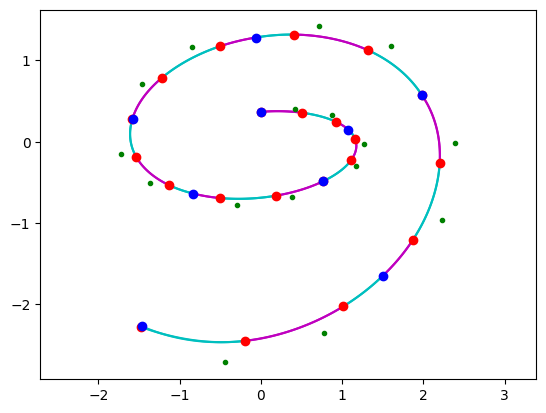

In [54]:
def optimize_coeffs_torch(ts, ps, c1s, c2s):
    assert ts[0] == 0.0
    assert ts[-1] == 1.0

    ts = torch.nn.Parameter(torch.tensor(ts).contiguous().double())
    ps = torch.nn.Parameter(torch.tensor(ps).contiguous().double())
    c1s = torch.nn.Parameter(torch.tensor(c1s).contiguous().double())
    c2s = torch.nn.Parameter(torch.tensor(c2s).contiguous().double())

    optimizer = torch.optim.LBFGS([ps, c1s, c2s], max_iter=50)

    loss = 0.0
    nfev = 0
    def closure():
        nonlocal nfev, loss
        optimizer.zero_grad()
        loss = get_loss_torch(ts, ps, c1s, c2s)
        loss.backward()
        ts.grad[0] = 0.0
        ts.grad[-1] = 0.0
        # print(loss.item()**0.5)
        nfev += 1
        return loss

    for epoch in range(1):
        optimizer.step(closure)

    return (nfev, loss.item()), (
        ts.detach().numpy(),
        ps.detach().numpy(),
        c1s.detach().numpy(),
        c2s.detach().numpy()
    )


n1 = 8
ts = np.linspace(0, 1, n1+1)
ps = fun(ts)
c1s, c2s = compute_c1_c2(ps)

(nfev, loss), (ts, ps, c1s, c2s) = optimize_coeffs_torch(ts, ps, c1s, c2s)
print(nfev, loss**0.5)

plt.figure()
get_loss(ts, ps, c1s, c2s, True)
plt.plot(initial_p[:,0], initial_p[:,1], 'ro')
plt.plot(ps[:,0], ps[:,1], 'bo')
plt.plot(c1s[:,0], c1s[:,1], 'g.')
plt.plot(c2s[:,0], c2s[:,1], 'g.')
plt.axis("equal")
plt.show()

20 4.892248675345799 0.03377016984570825
21 2.0103596856129435 0.0029454904488634666
26 0.3050829507523748 0.00017416324537506794
24 0.09992946957800329 3.558511520286319e-05
26 0.03577337008850026 1.0468132042539433e-05
24 0.01407146430931215 5.638932843219508e-06
23 0.005990206348613176 3.5216333642384057e-06
24 0.00272991470312294 1.9906275263145797e-06
25 0.001311431573893977 1.091319701062802e-06
20 0.0006553055397003147 5.194332742026357e-07
19 0.00033572840068749326 2.5889236191561477e-07
19 0.00017377342410854112 1.2865803823451295e-07
16 8.939529682510575e-05 6.639387919352202e-08
13 4.478355174060997e-05 3.28591852234763e-08
13 2.120839366154152e-05 1.1823529315471056e-08
11 9.036564577738484e-06 5.322130116388083e-09
7 3.1072344725699276e-06 5.2055793510324045e-09
6 6.235777385867056e-07 4.4802184278327304e-09


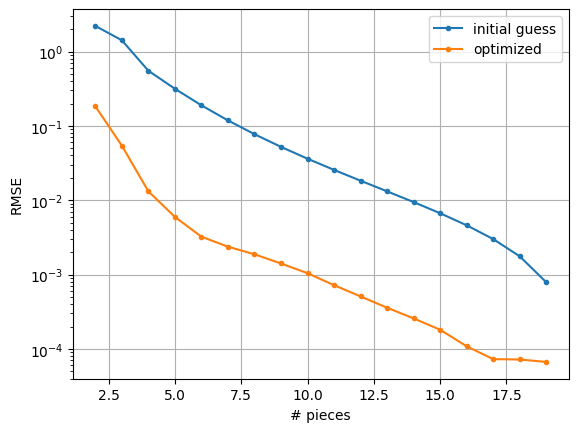

In [50]:
ns = range(2, N)
losses_0 = []
losses = []

for n1 in ns:
    ts = np.linspace(0, 1, n1+1)
    ps = fun(ts)
    c1s, c2s = compute_c1_c2(ps)
    loss0 = get_loss(ts, ps, c1s, c2s)
    (nfev, loss), (ts, ps, c1s, c2s) = optimize_coeffs_torch(ts, ps, c1s, c2s)
    print(nfev, loss0, loss)
    losses_0.append(loss0**0.5)
    losses.append(loss**0.5)

plt.figure()
plt.plot(ns, losses_0, '.-', label="initial guess")
plt.plot(ns, losses, '.-', label="optimized")
plt.yscale('log')
plt.grid()
plt.xlabel("# pieces")
plt.ylabel("RMSE")
plt.legend()
plt.show()

Objective for Gauss-Newton

In [118]:
def get_loss_torch_raw(ts, ps, c1s, c2s):
    assert ts[0].item() == 0.0 and ts[1].item() > 0.0
    assert ts[-1].item() == 1.0 and ts[-2].item() < 1.0

    initial_t_torch = torch.tensor(initial_t).double()

    all_ss = []  # (s, is_initial, idx)
    for i, t in enumerate(initial_t):
        all_ss.append((t, True, i))
    for i, t in enumerate(ts):
        all_ss.append((t, False, i))
    all_ss.sort(key=lambda _: _[0])

    all_residuals = []

    sp0i, sp1i = 0, 0
    for (s0, g0, i0), (s1, g1, i1) in zip(all_ss[:-1], all_ss[1:]):
        if g0:
            sp0i = i0
        else:
            sp1i = i0
        if not s0 < s1:
            if s1 > 0.0 and s0 < 1.0:
                all_residuals.append(None)
            continue

        # first piece
        cps0 = torch.tensor([
            initial_p[sp0i], initial_c1[sp0i], initial_c2[sp0i],
            initial_p[sp0i+1]
        ]).double()
        t00, t01 = initial_t_torch[sp0i], initial_t_torch[sp0i+1]
        ts0 = ((s0-t00)/(t01-t00), (s1-t00)/(t01-t00))
        coeffs0 = unwrap_cubic_spline_torch(cps0, *ts0)

        # second piece
        cps1 = torch.concatenate([
            ps[sp1i], c1s[sp1i], c2s[sp1i], ps[sp1i+1]
        ]).reshape((4, 2))
        t10, t11 = ts[sp1i], ts[sp1i+1]
        ts1 = ((s0-t10)/(t11-t10), (s1-t10)/(t11-t10))
        coeffs1 = unwrap_cubic_spline_torch(cps1, *ts1)

        # loss weight
        dx0 = (ts0[1]-ts0[0])/N
        dx1 = (ts1[1]-ts1[0])/(len(ts)-1)
        weight = dx0/(t01-t00) + dx1/(t11-t10)
        weight = dx0

        # integral (GL quadrature)
        dc = coeffs1 - coeffs0
        # gl_s = torch.tensor([.06943184420297371238,.33000947820757186759,.66999052179242813240,.93056815579702628761]).double()
        # gl_w = torch.tensor([.17392742256872692868,.32607257743127307131,.32607257743127307131,.17392742256872692868]).double()
        gl_s = torch.tensor([.03376524289842398609,.16939530676686774316,.38069040695840154568,.61930959304159845431,.83060469323313225683,.96623475710157601390]).double()
        gl_w = torch.tensor([.08566224618958517252,.18038078652406930378,.23395696728634552369,.23395696728634552369,.18038078652406930378,.08566224618958517252]).double()
        gl_ss = gl_s.unsqueeze(-1) ** torch.tensor([0, 1, 2, 3]).double()
        residuals = gl_ss @ dc
        w_residuals = torch.sqrt(weight * gl_w).unsqueeze(-1) * residuals
        all_residuals.append(w_residuals.flatten())

    assert len(all_residuals) == (len(ps)-1)+(len(initial_p)-1)-1
    output = torch.zeros(len(all_residuals), np.prod(residuals.shape)).double()
    for i, res in enumerate(all_residuals):
        if res is not None:
            output[i] = res
    return output.flatten()

params = [torch.tensor(ts), torch.tensor(ps), torch.tensor(c1s), torch.tensor(c2s)]
loss_0 = get_loss_torch(*params).item() ** 0.5
loss_1 = torch.sum(get_loss_torch_raw(*params)**2).item() ** 0.5
print(loss_0, loss_1)
rel_error = abs(loss_1/loss_0-1)
print(rel_error)
assert rel_error < 1e-6

0.0018760558512508794 0.0018760557905929452
3.2332691080050324e-08


SciPy least squares

Should converge in exactly 1 iteration for linear optimization problem

526 ms
102 0 0.0013265717714125613


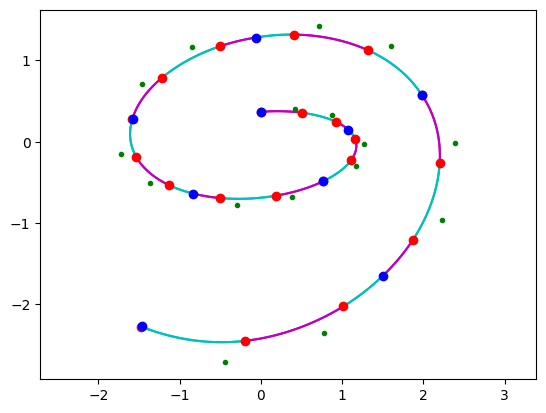

In [139]:
def optimize_coeffs_scipy(ts, ps, c1s, c2s):
    assert ts[0] == 0.0
    assert ts[-1] == 1.0

    def encode_params(ps, c1s, c2s):
        return np.concatenate((ps.flatten(), c1s.flatten(), c2s.flatten()))

    def decode_params(params, to_torch=False):
        len_ps = ps.size
        len_c1s = c1s.size
        len_c2s = c2s.size
        params = (
            params[:len_ps].reshape(-1, 2),
            params[len_ps:len_ps+len_c1s].reshape(-1, 2),
            params[len_ps+len_c1s:].reshape(-1, 2)
        )
        if to_torch:
            params = [torch.tensor(param).double() for param in params]
        return params

    nfev = 0
    def fun(ts, params):
        nonlocal nfev
        nfev += 1
        ps, c1s, c2s = decode_params(params, True)
        with torch.no_grad():
            ts = torch.tensor(ts).double()
            residuals = get_loss_torch_raw(ts, ps, c1s, c2s)
        return residuals.detach().numpy()

    njev = 0
    def jac(ts, params):
        nonlocal njev
        njev += 1
        params = torch.tensor(params, requires_grad=True).double()
        def fun(params):
            ps, c1s, c2s = decode_params(params, False)
            return get_loss_torch_raw(ts, ps, c1s, c2s)
        jac = torch.autograd.functional.jacobian(fun, params)
        # plt.figure()
        # plt.imshow(jac.detach().numpy().T != 0)
        # plt.show()
        return jac.detach().numpy()

    initial_params = encode_params(ps, c1s, c2s)
    result = scipy.optimize.least_squares(
        fun=lambda params: fun(ts, params),
        x0=initial_params,
        # jac=lambda params: jac(ts, params),
        method='trf'
    )
    optimized_params = result.x
    # nfev = result.nfev
    final_loss = result.cost

    return (nfev, njev, final_loss), (
        ts,
        *decode_params(optimized_params)
    )

n1 = 8
ts = np.linspace(0, 1, n1+1)
ps = fun(ts)
c1s, c2s = compute_c1_c2(ps)

t0 = perf_counter()
(nfev, njev, loss), (ts, ps, c1s, c2s) = optimize_coeffs_scipy(ts, ps, c1s, c2s)
t1 = perf_counter()
print(int(1000*(t1-t0)), 'ms')
print(nfev, njev, loss**0.5)

plt.figure()
get_loss(ts, ps, c1s, c2s, True)
plt.plot(initial_p[:,0], initial_p[:,1], 'ro')
plt.plot(ps[:,0], ps[:,1], 'bo')
plt.plot(c1s[:,0], c1s[:,1], 'g.')
plt.plot(c2s[:,0], c2s[:,1], 'g.')
plt.axis("equal")
plt.show()

45 4.892248675345799 0.016885084805068933
63 2.0103596856129435 0.0014727451993793732
54 0.3050829507523748 8.708098306512529e-05
66 0.09992946957800329 1.7791731060617705e-05
78 0.03577337008850026 5.233882206977547e-06
90 0.01407146430931215 2.817871827161471e-06
102 0.005990206348613176 1.7597926647086607e-06
114 0.00272991470312294 9.948904158987147e-07
126 0.001311431573893977 5.45524965388303e-07
138 0.0006553055397003147 2.586123010014033e-07
150 0.00033572840068749326 1.2896829406706114e-07
162 0.00017377342410854112 6.414479442883775e-08
174 8.939529682510575e-05 3.260230550298495e-08
186 4.478355174060997e-05 1.4878959592875754e-08
198 2.120839366154152e-05 5.364691654989855e-09
210 9.036564577738484e-06 2.2951531523290065e-09
222 3.1072344725699276e-06 1.0125260793606274e-09
234 6.235777385867056e-07 4.911961690290288e-10


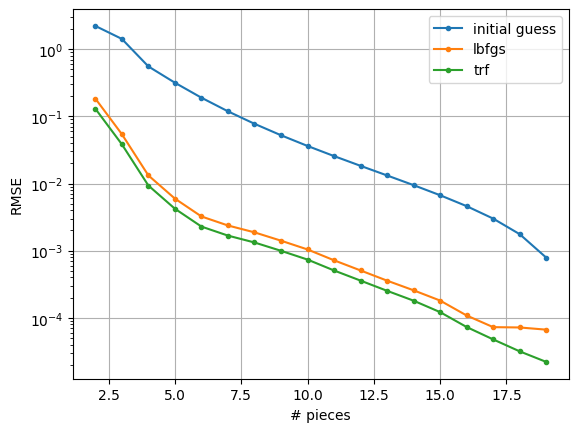

In [126]:
losses_1 = []

for n1 in ns:
    ts = np.linspace(0, 1, n1+1)
    ps = fun(ts)
    c1s, c2s = compute_c1_c2(ps)
    loss0 = get_loss(ts, ps, c1s, c2s)
    (nfev, njev, loss), (ts, ps, c1s, c2s) = optimize_coeffs_scipy(ts, ps, c1s, c2s)
    print(nfev, loss0, loss)
    losses_1.append(loss**0.5)

plt.figure()
plt.plot(ns, losses_0, '.-', label="initial guess")
plt.plot(ns, losses, '.-', label="lbfgs")
plt.plot(ns, losses_1, '.-', label="trf")
plt.yscale('log')
plt.grid()
plt.xlabel("# pieces")
plt.ylabel("RMSE")
plt.legend()
plt.show()

SciPy least squares, optimize for split locations

In [153]:
def optimize_coeffs_with_ts_scipy(ts, ps, c1s, c2s):
    if True:
        _, (ts, ps, c1s, c2s) = optimize_coeffs_scipy(ts, ps, c1s, c2s)

    assert ts[0] == 0.0
    assert ts[-1] == 1.0

    def encode_params(ts, ps, c1s, c2s):
        return np.concatenate((ts, ps.flatten(), c1s.flatten(), c2s.flatten()))

    def decode_params(params, to_torch=False):
        len_ts = ts.size-1
        len_ps = ps.size
        len_c1s = c1s.size
        len_c2s = c2s.size
        params = (
            params[:len_ts],
            params[len_ts:len_ts+len_ps].reshape(-1, 2),
            params[len_ts+len_ps:len_ts+len_ps+len_c1s].reshape(-1, 2),
            params[len_ts+len_ps+len_c1s:].reshape(-1, 2)
        )
        if to_torch:
            params = [torch.tensor(param).double() for param in params]
        return params

    softplus = torch.nn.Softplus()
    def map_ts(ts):
        # ts = torch.exp(ts)
        ts = softplus(ts)
        # ts = ts - torch.amin(ts) + 1.0
        ts = torch.cumsum(ts, 0)
        ts = torch.concatenate([torch.tensor([0.0]).double(), ts])
        return ts / ts[-1]
    
    def invmap_ts(ts):
        ts = torch.tensor(ts).double().contiguous()
        ts = ts[1:] - ts[:-1]
        return torch.log(ts)
        return torch.log(torch.exp(ts)-1)
        # return ts

    nfev = 0
    def fun(ts, params):
        nonlocal nfev
        nfev += 1
        ts, ps, c1s, c2s = decode_params(params, True)
        with torch.no_grad():
            ts = map_ts(ts)
            residuals = get_loss_torch_raw(ts, ps, c1s, c2s)
        print(torch.sum(residuals**2).item()**0.5)
        return residuals.detach().numpy()

    njev = 0
    def jac(ts, params):
        nonlocal njev
        njev += 1
        params = torch.tensor(params, requires_grad=True).double()
        def fun(params):
            ts, ps, c1s, c2s = decode_params(params, False)
            ts = map_ts(ts)
            return get_loss_torch_raw(ts, ps, c1s, c2s)
        jac = torch.autograd.functional.jacobian(fun, params)
        # plt.figure()
        # plt.imshow(jac.detach().numpy().T != 0)
        # plt.show()
        return jac.detach().numpy()

    initial_params = encode_params(
        invmap_ts(ts).detach().numpy(), ps, c1s, c2s)
    result = scipy.optimize.least_squares(
        fun=lambda params: fun(ts, params),
        x0=initial_params,
        jac=lambda params: jac(ts, params),
        x_scale='jac', method='trf'
    )
    optimized_params = result.x
    # nfev = result.nfev
    final_loss = result.cost

    return (nfev, njev, final_loss), (
        *decode_params(optimized_params),
    )

n1 = 8
ts = np.linspace(0, 1, n1+1)
ps = fun(ts)
c1s, c2s = compute_c1_c2(ps)

t0 = perf_counter()
(nfev, njev, loss), (ts, ps, c1s, c2s) = optimize_coeffs_with_ts_scipy(ts, ps, c1s, c2s)
t1 = perf_counter()
print(int(1000*(t1-t0)), 'ms')
print(nfev, njev, loss**0.5)

plt.figure()
get_loss(ts, ps, c1s, c2s, True)
plt.plot(initial_p[:,0], initial_p[:,1], 'ro')
plt.plot(ps[:,0], ps[:,1], 'bo')
plt.plot(c1s[:,0], c1s[:,1], 'g.')
plt.plot(c2s[:,0], c2s[:,1], 'g.')
plt.axis("equal")
plt.show()

0.0018760557905929452
1.1084196898422383
1.1084196898873988
1.1084196898669088
1.1084098078377818
1.0973380712576226
0.7930945382411665
0.40142384713228346
0.15522952084979405
0.04140329819241162
0.010607946529266804
0.0032180125918845255
0.001986394822684345
0.0018830429438206633
0.0018764681258901573
0.0018760752752481939
0.0018760554360289867
0.0018760554290736962
2730 ms
18 3 0.0013265715157798486


AssertionError: 

<Figure size 640x480 with 0 Axes>